In [1]:
# Import relevant library
import pandas as pd
import json
import networkx as nx
from itertools import combinations
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from sklearn.metrics.pairwise import cosine_similarity

In [254]:
# Import relevant library
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

# Read in dev set without dev edges information to test and tune model

In [56]:
dev_df = pd.read_csv('Data_dev_set_20200705_ver_1.csv')
#dev_df = dev_df.drop('Id', axis=1)
dev_df.shape #(4866, 23)

(4866, 23)

In [47]:
# Drop the irrelevant columns and prepare the development set to be split into train and test purpose
# Then the full development set will be used to train the final selected model
X_dev = dev_df.drop(columns = ['Expected', 'Source', 'Sink'], axis=1)
#print(X_dev[5])
Y_dev = dev_df['Expected']
#print(Y_dev[:5])

# Try RF with dev set train and test

In [48]:
# Split the development set into train (70%) and test(30%) sets.
X_train, X_test, Y_train, Y_test = train_test_split(X_dev, Y_dev, test_size=0.3, random_state=0)

In [49]:
# define the first random forest model with default parameters.
rf_clf_default = RandomForestClassifier(random_state = 0)
rf_clf_default.fit(X_train, Y_train)  

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [50]:
# Check the in sample accuracy, out of sample accuracy and AUC at test set.

print('Accuracy of train', rf_clf_default.score(X_train, Y_train)) #accuracy in sample is tooooo high, may overfitting
print('Accuracy of test', rf_clf_default.score(X_test, Y_test))

Y_score = rf_clf_default.predict_proba(X_test)[:, 1] 
AUC = roc_auc_score(Y_test, Y_score)
print('AUC', AUC)

Accuracy of train 1.0
Accuracy of test 0.7534246575342466
AUC 0.8338812049039674


# Feature selection

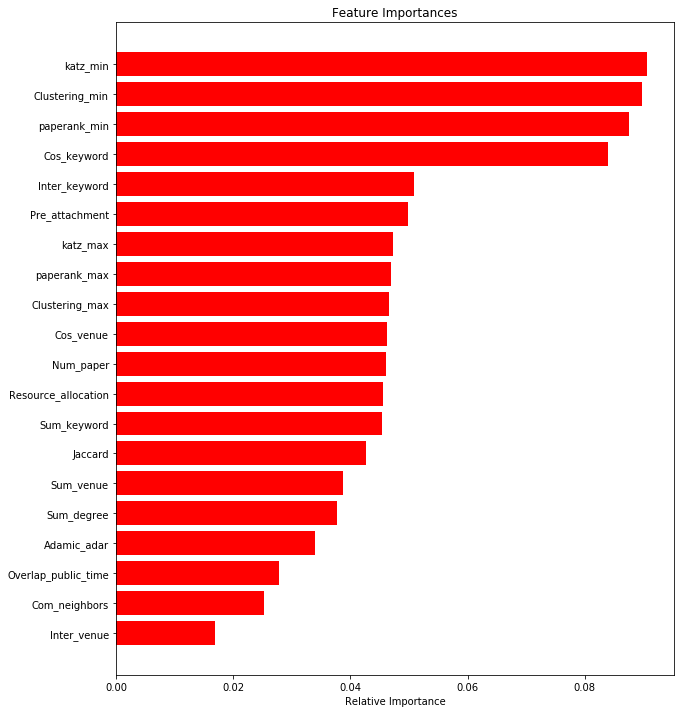

In [28]:
# Plot the importance graph, and this is used in the final report.

features_df = train_df.drop(columns = ['Expected', 'Source', 'Sink'], axis=1)
features = features_df.columns
importances = rf_clf_default.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [29]:
for i in range(len(features)):
    print(features[i], importances[i])

Overlap_public_time 0.027899368084521335
Cos_venue 0.0463249542717581
Cos_keyword 0.08403245581673635
Inter_venue 0.016904842175012667
Inter_keyword 0.05082392424999337
Num_paper 0.046058461978607926
Jaccard 0.04268347067226285
Resource_allocation 0.04559718066376191
Pre_attachment 0.0498252664760743
Adamic_adar 0.03390575390744637
Com_neighbors 0.025287545026482137
Clustering_min 0.08971701724369914
Clustering_max 0.04654742086665619
Sum_degree 0.037699447596138545
Sum_keyword 0.04538211913609131
Sum_venue 0.03880618927525643
katz_min 0.09067528458078751
katz_max 0.04735109262408839
paperank_min 0.08746941914570128
paperank_max 0.04700878620892386


In [55]:
print(sorted(importances))

[0.016904842175012667, 0.025287545026482137, 0.027899368084521335, 0.03390575390744637, 0.037699447596138545, 0.03880618927525643, 0.04268347067226285, 0.04538211913609131, 0.04559718066376191, 0.046058461978607926, 0.0463249542717581, 0.04654742086665619, 0.04700878620892386, 0.04735109262408839, 0.0498252664760743, 0.05082392424999337, 0.08403245581673635, 0.08746941914570128, 0.08971701724369914, 0.09067528458078751]


In [57]:
# drop importance with less than 0.04 not drop common neighbor
'Inter_venue', 'Com_neighbors', 'Overlap_public_time', 'Admic_adar', 'Sum_degree', 'Sum_venue'

('Inter_venue',
 'Com_neighbors',
 'Overlap_public_time',
 'Admic_adar',
 'Sum_degree',
 'Sum_venue')

In [150]:
# Refit the model with 5 less variable (not delete the common neighbours)
X_dev = dev_df.drop(columns = ['Expected', 'Source', 'Sink', 'Inter_venue', 'Overlap_public_time', 'Adamic_adar', 'Sum_degree', 'Sum_venue'], axis=1)
#print(X_dev[5])
Y_dev = dev_df['Expected']
#print(Y_dev[:5])

In [60]:
# Split the new dev set
X_train, X_test, Y_train, Y_test = train_test_split(X_dev, Y_dev, test_size=0.3, random_state=0)
# still with default parameter
rf_clf_default = RandomForestClassifier(random_state = 0)
rf_clf_default.fit(X_train, Y_train)  

#In sample accuracy, out of sample accuracy and AUC at test set
print('Accuracy of train', rf_clf_default.score(X_train, Y_train)) #accuracy in sample is tooooo high, may overfitting
print('Accuracy of test', rf_clf_default.score(X_test, Y_test))

Y_score = rf_clf_default.predict_proba(X_test)[:, 1] 
AUC = roc_auc_score(Y_test, Y_score)
print('AUC', AUC)

Accuracy of train 1.0
Accuracy of test 0.75
AUC 0.8261893887707942


# First time of tuning 

In [211]:
# hyperparameter tuning
'''Original code was generated by Will Koehrsen, please check the following website
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74'''

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [5, 10, 20, 30, 40, 50]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [213]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_clf_grid = RandomForestClassifier(random_state = 0)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use AUC as the selection cretire
rf_random = RandomizedSearchCV(estimator = rf_clf_grid, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1, 
                               scoring = 'roc_auc')

In [214]:
# Grid search
girdsearch = rf_random.fit(X_dev, Y_dev)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 31.5min finished


In [215]:
# Print out the selected parameters
girdsearch.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 30}

In [216]:
# Print out the selected random forest model
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [217]:
# Refit the new model
rf_clf_tune1 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [219]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dev, Y_dev, test_size=0.3, random_state=0)

In [220]:
rf_clf_tune1.fit(X_train, Y_train)  

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [222]:
# Check the in sample accuracy, out of sample accuracy and AUC at test set.
print('Accuracy of train', rf_clf_tune1.score(X_train, Y_train))
print('Accuracy of dev', rf_clf_tune1.score(X_test, Y_test))

Y_score = rf_clf_tune1.predict_proba(X_test)[:, 1] 
AUC = roc_auc_score(Y_test, Y_score)
print('AUC', AUC)

Accuracy of train 1.0
Accuracy of dev 0.7541095890410959
AUC 0.8321520733602852


In [245]:
#refit the new model with all development set
X_dev = dev_df.drop(columns = ['Expected', 'Source', 'Sink', 'Inter_venue', 'Overlap_public_time', 'Adamic_adar', 'Sum_degree', 'Sum_venue'], axis=1)
#print(X_dev[5])
Y_dev = dev_df['Expected']
#print(Y_dev[:5])

In [248]:
# refit the new models
rf_clf_tune1.fit(X_dev, Y_dev)  

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [236]:
# predict the public test set with the new model
# read in the public test set
public_test_df = pd.read_csv('Data_public_test_set_20200705ver1.csv')
public_test_df.head() #(4460, 23)

,Id,Source,Sink,Overlap_public_time,Cos_venue,Cos_keyword,Inter_venue,Inter_keyword,Num_paper,Jaccard,...,Com_neighbors,Clustering_min,Clustering_max,Sum_degree,Sum_keyword,Sum_venue,katz_min,katz_max,paperank_min,paperank_max
0,1,2,3007,4,0.0,0.6480,0.0,23.0,1.625000,0.000000,...,0,0.202899,0.666667,27,43.0,8.0,0.015028,0.016688,0.000085,0.000420
1,2,3,127,3,0.0,0.8477,0.0,43.0,4.000000,0.200000,...,2,0.400000,0.466667,12,46.0,3.0,0.014965,0.015139,0.000101,0.000165
2,3,3,2254,3,0.0,0.9446,0.0,161.0,4.916667,0.000000,...,0,0.309091,0.400000,17,71.0,8.0,0.015139,0.015647,0.000165,0.000251
3,4,3,2727,1,0.0,0.6747,0.0,23.0,4.666667,0.250000,...,2,0.400000,0.833333,10,39.0,1.0,0.014989,0.015139,0.000086,0.000165
4,5,4,1147,8,0.0,0.9030,0.0,139.0,3.125000,0.017544,...,1,0.267974,0.756410,58,77.0,3.0,0.016422,0.018994,0.000303,0.000485


In [237]:
# Drop the irrelevant columns to prepare for the test input
public_test_df = public_test_df.drop(columns = ['Id', 'Source', 'Sink', 'Inter_venue', 'Overlap_public_time', 'Adamic_adar', 'Sum_degree', 'Sum_venue'], axis=1)
X_final_test = public_test_df
#print(X_final_test[0])

In [249]:
# Predict the public test set
result_class_2 = rf_clf_tune1.predict_proba(X_final_test)[:, 1] 
print(result_class_2[:5])
label1 = rf_clf_tune1.predict(X_final_test)
print(label1[:5])

[0.58944444 0.98666667 0.22388911 0.99388889 0.45666667]
[ 1  1 -1  1 -1]


In [250]:
# Generate the output dataframe
predicted = []
for i in result_class_2:
    predicted.append(i)
    
id_value = []
for i in range(1, len(predicted) + 1):
    id_value.append(i)

data = {'Id': id_value, 'Predicted': predicted}
output_df = pd.DataFrame(data, columns = ['Id', 'Predicted'])

In [251]:
# Check the data frame
output_df.head()

,Id,Predicted
0,1,0.589444
1,2,0.986667
2,3,0.223889
3,4,0.993889
4,5,0.456667


In [252]:
# Export the csv file
output_df.to_csv('test_ouput_20200705_ver_2.csv', index = False)

# Tune the model (Final tuning)

In [275]:
# Regenerate the development set with 5 less features
X_dev = dev_df.drop(columns = ['Expected', 'Source', 'Sink', 'Inter_venue', 'Overlap_public_time', 'Adamic_adar', 'Sum_degree', 'Sum_venue'], axis=1)
#print(X_dev[5])
Y_dev = dev_df['Expected']
#print(Y_dev[:5])

In [199]:
# hyperparameter tuning
'''Original code was generated by Will Koehrsen, please check the following website
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74'''

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [5, 10, 20, 30, 40, 50]
# Minimum number of samples required to split a node
min_samples_split = [4, 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 4, 5]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [200]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_clf_grid = RandomForestClassifier(random_state = 0)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use AUC as the selection criteria
rf_random = RandomizedSearchCV(estimator = rf_clf_grid, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1, 
                               scoring = 'roc_auc')

In [201]:
# Grid search
girdsearch = rf_random.fit(X_dev, Y_dev)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.3min finished


In [202]:
# Print out the selected parameter
girdsearch.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 30}

In [203]:
# Print out the selected new model
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [256]:
# Redifine the final random forest
# And the refit the model
rf_clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [276]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dev, Y_dev, test_size=0.3, random_state=0)

In [258]:
rf_clf.fit(X_train, Y_train)  

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [261]:
# Check the in sample accuracy, out of sample accuracy and AUC at test set.
print('Accuracy of train', rf_clf.score(X_train, Y_train))
print('Accuracy of dev', rf_clf.score(X_test, Y_test))

Y_score = rf_clf.predict_proba(X_test)[:, 1] 
label = rf_clf.predict(X_test)
AUC = roc_auc_score(Y_test, Y_score)
print('AUC', AUC)

Accuracy of train 0.942160892542572
Accuracy of dev 0.7424657534246575
AUC 0.8285960767508866


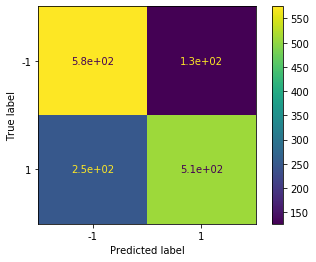

In [260]:
# Plot the confusion matrix for the test set.
plot_confusion_matrix(rf_clf, X_test, Y_test)

In [238]:
#refit the model with all dev set
X_dev = dev_df.drop(columns = ['Expected', 'Source', 'Sink', 'Inter_venue', 'Overlap_public_time', 'Adamic_adar', 'Sum_degree', 'Sum_venue'], axis=1)
#print(X_dev[5])
Y_dev = dev_df['Expected']
#print(Y_dev[:5])

In [240]:
rf_clf.fit(X_dev, Y_dev)  

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [241]:
# Predict the public test set
result_class_1 = rf_clf.predict_proba(X_final_test)[:, 1] 
print(result_class_1[:5])
label = rf_clf.predict(X_final_test)
print(label[:5])

[0.57368098 0.98856061 0.21920732 0.99333333 0.49752858]
[ 1  1 -1  1 -1]


In [242]:
# Generate the output dataframe
predicted = []
for i in result_class_1:
    predicted.append(i)
    
id_value = []
for i in range(1, len(predicted) + 1):
    id_value.append(i)

data = {'Id': id_value, 'Predicted': predicted}
output_df = pd.DataFrame(data, columns = ['Id', 'Predicted'])

In [243]:
output_df.head()

,Id,Predicted
0,1,0.573681
1,2,0.988561
2,3,0.219207
3,4,0.993333
4,5,0.497529


In [244]:
# Export the final output which was used in the Kaggle competition.
output_df.to_csv('test_ouput_20200705_ver_1.csv', index = False)